## import libraries

In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')


#sns.set_palette("husl")
#sns.color_palette("husl", 8)

## read data and store

In [2]:
df = pd.read_csv("https://bus-api-oqbw.onrender.com/bus/get_all")
df

,id,lat,lon,time,acce
0,8,18.404205,-66.046492,9:24:32,0.000000
1,9,18.404124,-66.047754,9:24:57,0.000000
2,10,18.404005,-66.048628,9:25:29,0.000000
3,11,18.403444,-66.049969,9:26:11,0.000000
4,12,18.404178,-66.050321,9:26:41,0.000000
...,...,...,...,...,...
253,261,18.406167,-66.043272,14:42:46,5.280023
254,262,18.407040,-66.042000,14:43:22,1.728896
255,263,18.406225,-66.043042,14:45:14,3.876215
256,264,18.403648,-66.045337,14:48:24,4.533223


## clean and fix data a bit

*Constants*

In [3]:
#seed for random vals
seed = 42

*Set stops*

In [4]:
paradas = {
    4: {
    'lat':18.403636,
    'lon': -66.045492
},
5: {
    'lat': 18.403751,
     'lon': -66.046593
},
6:
 {

   
        'lat': 18.403879,
        'lon': -66.048199
       
    },
13:
    {
      
        'lat': 18.403955,
        'lon': -66.049898
        
    },
24: {
        'lat': 18.404698,
        'lon': -66.050468
      },  
23: {
        'lat': 18.406440,
        'lon': -66.050140
      },  
    

20: {
        'lat': 18.407062,
        'lon': -66.049323
       
    },
    19:{
     
        'lat': 18.406503,
        'lon': -66.048520
       
    },
9: {
        'lat': 18.406018,
        'lon': -66.047806
      },  
    
   10: {
        'lat': 18.406766,
        'lon': -66.046771
      },  
    
11: {
        'lat': 18.406078,
        'lon': -66.044770
      },  

   '2.1': {
        'lat': 18.406243,
        'lon': -66.043161
      },  
    
   1: {
        'lat' : 18.407170,
        'lon' : -66.041989
      }, 

   '2.2': {
        'lat': 18.406243,
        'lon': -66.043161
      },  
    
    3: {
        'lat': 18.404856,
        'lon': -66.044836
      },  
    }

def shortest_distance_from_point(lat,lon):
    #calculate shortest distance

    shortest_distance = 9999999
    pinpoint_parada = None

    for parada in paradas:
        coords = paradas[parada]
        distance = math.sqrt(((lat - coords['lat'])**2) + ((lon-coords['lon'])**2))

        if shortest_distance> distance:
            shortest_distance = distance
            pinpoint_parada = parada

    return pinpoint_parada

df['stop'] = df.apply(lambda x: shortest_distance_from_point(x.lat, x.lon),axis=1)

#add point for next stop
parada_num = list(paradas.keys())
parada_num.insert(-1,2)

def add_next_stop(stop):
    if stop in parada_num and not stop == 2:
        x = parada_num.index(stop)
        if x < len(parada_num)-1:
            next = parada_num[x + 1]
        else:
            next = parada_num[0]
        return next
    elif stop == 2:
        return stop
    else:
        return pd.NA

df['next_stop'] = df['stop'].apply(lambda x: add_next_stop(x))

In [5]:
#drop incorrect data
df_rm = df[df.index < 26]
df = df.drop(df_rm.index, axis=0)
df = df.reset_index()

*Calculate times*

In [6]:
##Convert times to seconds

#elapsed time
elapsed = [0]
for i in range(1, len(df["time"])):
    t = pd.to_datetime(df["time"][i],format='%H:%M:%S') - pd.to_datetime(df["time"][i-1],format='%H:%M:%S')
    elapsed.append(t.total_seconds())

df['elapsed'] = elapsed

#add time -> seconds column
ts = df['time'].apply( lambda d : pd.to_datetime(d,format='%H:%M:%S'))
ts = ts.apply( lambda d : d.time() )
sc = ts.apply( lambda d : (d.hour * 60 + d.minute) * 60 + d.second)
df['time_Seconds'] = sc

df

,index,id,lat,lon,time,acce,stop,next_stop,elapsed,time_Seconds
0,26,34,18.403981,-66.046373,8:42:35,0.000000,5,6,0.0,31355
1,27,35,18.404105,-66.048489,8:43:13,0.000000,6,13,38.0,31393
2,28,36,18.404201,-66.049903,8:43:56,0.000000,13,24,43.0,31436
3,29,37,18.405122,-66.050338,8:44:52,4.572018,24,23,56.0,31492
4,30,38,18.406180,-66.050259,8:45:22,3.924368,23,20,30.0,31522
...,...,...,...,...,...,...,...,...,...,...
227,253,261,18.406167,-66.043272,14:42:46,5.280023,2.1,1,268.0,52966
228,254,262,18.407040,-66.042000,14:43:22,1.728896,1,2.2,36.0,53002
229,255,263,18.406225,-66.043042,14:45:14,3.876215,2.1,1,112.0,53114
230,256,264,18.403648,-66.045337,14:48:24,4.533223,4,5,190.0,53304


*More cleaning*

In [7]:
#remove unnecessary columns
df = df.drop(columns=['id','acce','index'])

In [8]:
#add new empty column
df['round_trip'] = pd.NA

#calculate times between full round stop

for s in parada_num:
    df_r = df[df['stop'] == s]
    dr = df_r.time_Seconds.diff()
    for i in dr.index.values:
        df.iloc[i,df.columns.get_loc('round_trip')] = dr.loc[i]

#set negative times to NaN
df['elapsed'] = df['elapsed'].mask(df['elapsed'] < 1)
#set round trips that are too short (errors) to NaN
df['round_trip'] = df['round_trip'].mask(df['round_trip'] < 600)

## observe data spread

Correlation between vars
               elapsed  time_Seconds  round_trip
elapsed       1.000000      0.248068    0.256299
time_Seconds  0.248068      1.000000    0.959348
round_trip    0.256299      0.959348    1.000000


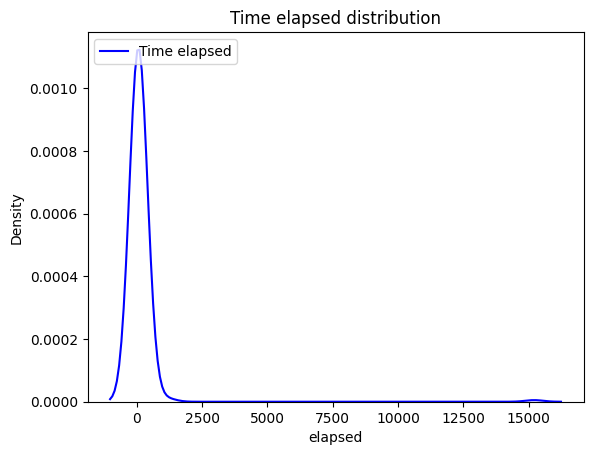

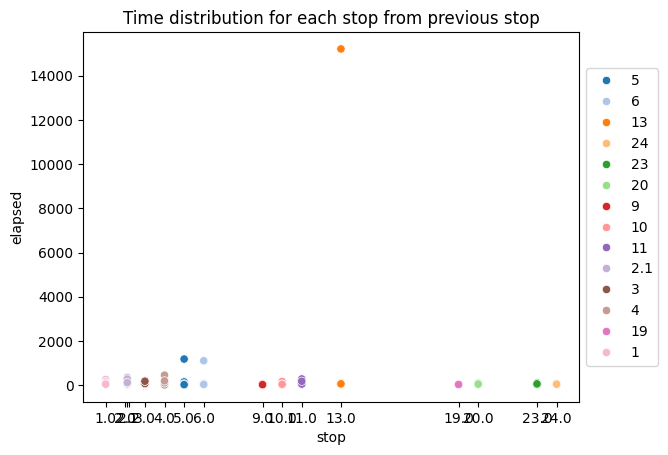

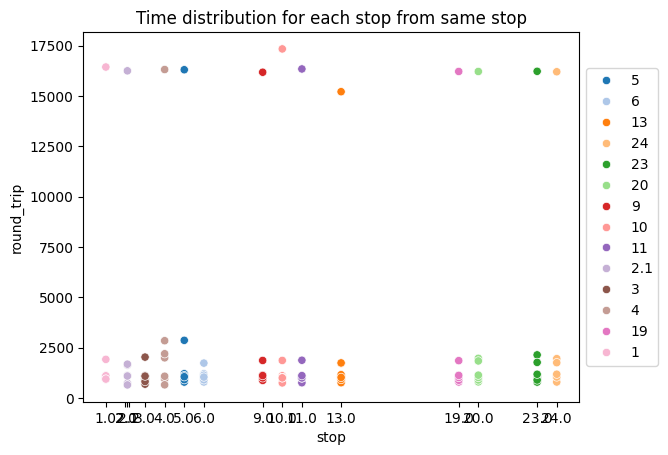

In [9]:
df_c = df[['elapsed', 'time_Seconds', 'round_trip']]
cor = df_c.corr()
print("Correlation between vars")
print(cor)

sns.kdeplot(x=df["elapsed"], color='blue', label="Time elapsed")
plt.legend(loc="upper left")
plt.title("Time elapsed distribution")
plt.show()

ps = pd.Series(parada_num)
ps = ps.apply(lambda x: float(x))

sns.scatterplot(data=df, x='stop', y='elapsed',hue='stop',palette="tab20").set_xticks(ps)
plt.title("Time distribution for each stop from previous stop")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

sns.scatterplot(data=df, x='stop', y='round_trip',hue='stop',palette="tab20").set_xticks(ps)
plt.title("Time distribution for each stop from same stop")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [10]:
print(df.to_string())

df.to_csv('cleaned.csv', index=False)  

           lat        lon      time stop next_stop  elapsed  time_Seconds round_trip
0    18.403981 -66.046373   8:42:35    5         6      NaN         31355        NaN
1    18.404105 -66.048489   8:43:13    6        13     38.0         31393        NaN
2    18.404201 -66.049903   8:43:56   13        24     43.0         31436        NaN
3    18.405122 -66.050338   8:44:52   24        23     56.0         31492        NaN
4    18.406180 -66.050259   8:45:22   23        20     30.0         31522        NaN
5    18.407194 -66.049543   8:45:59   20        19     37.0         31559        NaN
6    18.406721 -66.049000   8:46:16   20        19     17.0         31576        NaN
7    18.406061 -66.048104   8:46:47    9        10     31.0         31607        NaN
8    18.406627 -66.046957   8:47:16   10        11     29.0         31636        NaN
9    18.406023 -66.044951    8:48:3   11       2.1     47.0         31683        NaN
10   18.406176 -66.043161   8:48:48  2.1         1     45.0      